In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import mdtraj as md
import mcg
import h5py
import pandas as pd

import matplotlib_config as cfg
import fnmatch
from matplotlib import cm as cmpl
from matplotlib.colors import PowerNorm

from cmap import Colormap
import cmasher as cmr
import matplotlib.colors as mcolors 

In [2]:

cm = Colormap('crameri:lipari')
mpl_cm = cm.to_mpl().reversed()

cmap_colors = mpl_cm(np.linspace(0, 1, 256))

truncate_point = 0.1

truncated_colors = cmap_colors[int(256 * truncate_point):]
cmap = mcolors.LinearSegmentedColormap.from_list('truncated_cmap', truncated_colors)

In [3]:
step2us = 2e-9
burst = 1e5

grade_burst = 10

In [4]:
datafolders =['data_mu175_chain0_batch_0/', 'data_mu175_chain0_batch_1/' , 'data_mu175_chain0_batch_2/']
#folder = 'archive/wrong_wrapping/data_mu180'
gro_folder = 'gro_files'

In [5]:
top_file = os.path.join(gro_folder, 'conf.gro')

In [6]:
def build_pd(run_folder_path):
    logfile_path = os.path.join(run_folder_path, 'log.txt')
    weights = np.load(os.path.join(run_folder_path, 'p_sel_sums.npy'))[1:]
    
    # Load the log file
    df = pd.read_fwf(
        logfile_path,
        header=0,
        widths=[21] * 7,
        strip=True
    )
    df.columns = df.columns.str.strip()
    
    # Initialize weights column with zeros
    df['Weights'] = 0.0
    
    # Get successful rows
    successful_indices = df[df['Successful'] == True].index
    
    # Sanity check
    assert len(successful_indices) == len(weights), "Mismatch between successful trajectories and weights"
    
    # Assign weights to successful trajectories
    for idx, weight in zip(successful_indices, weights):
        df.at[idx, 'Weights'] = weight

    return df

In [7]:

# Dictionary to store all run data
run_data = {}

for datafolder in datafolders:
    print(datafolder)
    run_data[datafolder] = {}
    
    for run_folder in os.listdir(datafolder):
        run_folder_path = os.path.join(datafolder, run_folder)
        
        # Skip non-directories and hidden folders
        if not os.path.isdir(run_folder_path) or run_folder.startswith('.'):
            continue
        
        # Initialize entry for this run
        run_data[datafolder][run_folder] = {
            'log': None,
            'index_succ': {},
            'trial_rej': {},
            'cages': {}
        }
        
        df = build_pd(run_folder_path)
        run_data[datafolder][run_folder]['log'] = df
        
        # Process successful trials
        for succ_file in os.listdir(run_folder_path):
            if succ_file.startswith('cv_') and not succ_file.endswith('_0.txt'):
                try:
                    trial_num = int(succ_file.split('_')[1].split('.')[0])
                    trial_path = os.path.join(run_folder_path, succ_file)
                    frames, mcg_values = np.loadtxt(trial_path, skiprows=1, unpack=True)

                    cutoff_mask = mcg_values >= 300
                    B_cutoff = int(frames[np.argmax(cutoff_mask)] / burst) if np.any(cutoff_mask) else None

                    run_data[datafolder][run_folder]['index_succ'][trial_num] = {
                        'frames': frames,
                        'mcg_values': mcg_values,
                        'B_cutoff': B_cutoff,
                        'file_path': os.path.join(run_folder_path, f'traj_{trial_num}.dcd')
                    }

                    parts = ['cages']
                    parts.extend(datafolder.split('_')[1:])
                    cagefolder = '_'.join(parts)

                    
                    try:
                        times, _, Cages_512, Cages_62512, Cages_64512, Cages_4151062, _ = np.loadtxt(f'{cagefolder}/{run_folder}/traj_{trial_num}_stride_10_grade.txt', skiprows = 1, unpack = True)
    
                        run_data[datafolder][run_folder]['cages'][trial_num] = {
                        'frames': times,
                        '512': Cages_512,
                        '62512': Cages_62512,
                        '64512': Cages_64512,
                        '4151062': Cages_4151062
                        }
                    except Exception as cage_error:
                        print(f"Cage data not available for trial {trial_num} in {run_folder}: {cage_error}")
                    

                except (ValueError, IndexError) as e:
                    print(f"Error processing {succ_file} in {run_folder}: {e}")
                    continue
                
    
        
        # Process rejected trials
        for rej_file in os.listdir(run_folder_path):
            if rej_file.startswith('rejected_cv_trial_') and not rej_file.endswith('_0.txt'):
                try:
                    trial_num = int(rej_file.split('_')[3].split('.')[0])
                    trial_path = os.path.join(run_folder_path, rej_file)
                    frames, mcg_values = np.loadtxt(trial_path, skiprows=1, unpack=True)

                    run_data[datafolder][run_folder]['trial_rej'][trial_num] = {
                        'frames': frames,
                        'mcg_values': mcg_values
                    }

                except (ValueError, IndexError) as e:
                    print(f"Error processing {rej_file} in {run_folder}: {e}")
                    continue
        


data_mu175_chain0_batch_0/
data_mu175_chain0_batch_1/
data_mu175_chain0_batch_2/


## RESAMPLING

In [8]:
chain = [datafolders[0], datafolders[1], datafolders[2]]

In [9]:
# make list of all trajectories 

all_trajectories = []
all_weights = []

for run_idx in range(12):
    for dataset in chain:
        df = run_data[dataset][f'run_{run_idx}']['log']
        df_acc = df[df['Successful'] == True]
        for acc_traj_idx in sorted(run_data[dataset][f'run_{run_idx}']['index_succ']):

            #print(acc_traj_idx)

            current_index_df = df[df['Index'] == acc_traj_idx]
            weight = current_index_df['Weights'].values[0]

            all_trajectories.append((dataset, run_idx, acc_traj_idx))
            all_weights.append(1/weight)

p_sel_sums_norm = all_weights/np.sum(all_weights)

n_samples = 10 * len(p_sel_sums_norm)
indices = np.random.choice(len(all_trajectories), size=n_samples, replace=True, p=p_sel_sums_norm)
trajectory_ensemble_AA_resampled = [all_trajectories[i] for i in indices]

## CAGE COUNT PLOTS

In [10]:
cage_ratios = []
cages_62512 = []
cages_4151062 = []

cage_ratios_halfway = []
cages_4_halfway = []
cages_5_halfway = []

for dataset in run_data:
    for run in run_data[dataset]:
    
        #print(successful_df)
    
        for idx in run_data[dataset][run]['cages'].keys():
            
            frames = run_data[dataset][run]['cages'][idx]['frames']
            #print(frames)
            Cages_512 = run_data[dataset][run]['cages'][idx]['512']
            Cages_62512 = run_data[dataset][run]['cages'][idx]['62512']
            Cages_64512 = run_data[dataset][run]['cages'][idx]['64512']
            Cages_4151062 = run_data[dataset][run]['cages'][idx]['4151062']
    
            cage_ratio = Cages_62512[-1] / Cages_4151062[-1]
    
            N = len(frames)
    
            cage_ratios.append(cage_ratio)
            cages_62512.append(Cages_62512[-1])
            cages_4151062.append(Cages_4151062[-1])
    
            cage_ratios_halfway.append(Cages_62512[N // 2] / Cages_4151062[N // 2])
            cages_4_halfway.append(Cages_4151062[N // 2])
            cages_5_halfway.append(Cages_62512[N // 2])
            
    
            '''plt.plot(frames * step2us, Cages_512, label = '512', c=cfg.colors['lightblue'])
            plt.plot(frames * step2us, Cages_62512, label = '62512', c=cfg.colors['purple'])
            plt.plot(frames * step2us, Cages_64512, label = '64512', c=cfg.colors['red'])
            plt.plot(frames * step2us, Cages_4151062, label = '4151062', c=cfg.colors['lightgreen'])'''
            #plt.scatter(sp_idx * step2us, sp_cv, zorder = 100, c = 'black')
            #c += 1
            #plt.show()

'''#plt.legend()
plt.xlabel('time ($\mu s$)')
plt.ylabel('Cage Number')'''

/scratch_local/ipykernel_2489709/3802413003.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  cage_ratios_halfway.append(Cages_62512[N // 2] / Cages_4151062[N // 2])


"#plt.legend()\nplt.xlabel('time ($\\mu s$)')\nplt.ylabel('Cage Number')"

In [11]:
for dataset in run_data:
    for run in run_data[dataset]: 
        for idx in run_data[dataset][run]['cages'].keys():
        
            
            Cages_512 = run_data[dataset][run]['cages'][idx]['512']
            Cages_62512 = run_data[dataset][run]['cages'][idx]['62512']
            Cages_64512 = run_data[dataset][run]['cages'][idx]['64512']
            Cages_4151062 = run_data[dataset][run]['cages'][idx]['4151062']            
        
            cage_ratio = Cages_62512[-1] / Cages_4151062[-1]
            cage_ratio_frames = Cages_62512 / Cages_4151062
        
            total_cage_count_frames = Cages_512 + Cages_62512 + Cages_64512 + Cages_4151062
        
            if cage_ratio < 1:
                structure = 'amorphous'
            if cage_ratio >= 1:
                structure = 'crystalline'

            cage_ratio_frames = Cages_62512 - Cages_4151062
        
            run_data[dataset][run]['index_succ'][idx]['CageRatio'] = cage_ratio
            run_data[dataset][run]['index_succ'][idx]['CageRatioFrames'] = cage_ratio_frames
            run_data[dataset][run]['index_succ'][idx]['Structure'] = structure
            run_data[dataset][run]['index_succ'][idx]['CageCount'] = total_cage_count_frames

/scratch_local/ipykernel_2489709/277473048.py:12: RuntimeWarning: invalid value encountered in divide
  cage_ratio_frames = Cages_62512 / Cages_4151062
/scratch_local/ipykernel_2489709/277473048.py:12: RuntimeWarning: divide by zero encountered in divide
  cage_ratio_frames = Cages_62512 / Cages_4151062


In [12]:
#n = len(successful_trajs)
#colors_mpl = cm.tab20(np.linspace(0, 1, n))
#c = 0

cage_ratios = []
cages_62512 = []
cages_4151062 = []

cage_ratios_halfway = []
cages_4_halfway = []
cages_5_halfway = []

cages_62512_traj = []


cage_ratio_traj = []
mcg_traj = []

all_Cages_62512 = []
all_Cages_4151062 = []

for dataset, run_idx, acc_traj_idx in trajectory_ensemble_AA_resampled:

    run = f'run_{run_idx}'

    
    Cages_512 = run_data[dataset][run]['cages'][acc_traj_idx]['512']
    Cages_62512 = run_data[dataset][run]['cages'][acc_traj_idx]['62512']
    Cages_64512 = run_data[dataset][run]['cages'][acc_traj_idx]['64512']
    Cages_4151062 = run_data[dataset][run]['cages'][acc_traj_idx]['4151062']


    all_Cages_62512.append(Cages_62512)
    all_Cages_4151062.append(Cages_4151062)
    
    mcg_values = mcg_values = run_data[dataset][run]['index_succ'][acc_traj_idx]['mcg_values']

    mcg_traj.append(mcg_values)


    cage_ratio = Cages_62512[-1] / Cages_4151062[-1]
    #cage_ratio_frames = Cages_62512 / Cages_4151062

    #total_cage_count_frames = Cages_512 + Cages_62512 + Cages_64512 + Cages_4151062
    
    cage_ratio_traj.append( Cages_62512 - Cages_4151062 )
    #print(cage_ratio_traj)
    
    cage_ratios.append(cage_ratio)
    cages_62512.append(Cages_62512[-1])
    cages_4151062.append(Cages_4151062[-1])

    cages_62512_traj.append(Cages_62512)
    

## ONLY ENDPOINTS

In [13]:
x = np.arange(100)

In [14]:
cm_name = 'crameri:acton'
cm_name = 'crameri:lipari'
cm_name = 'seaborn:rocket'
#cm_name = 'seaborn:flare'
#cm_name = 'colorbrewer:YlGnBu_9'


cm = Colormap(f'{cm_name}')
mpl_cm = cm.to_mpl().reversed()

cmap_colors = mpl_cm(np.linspace(0, 1, 256))
truncate_point = 0.2

truncated_colors = cmap_colors[int(256 * truncate_point):]
cmap = mcolors.LinearSegmentedColormap.from_list('truncated_cmap', truncated_colors)

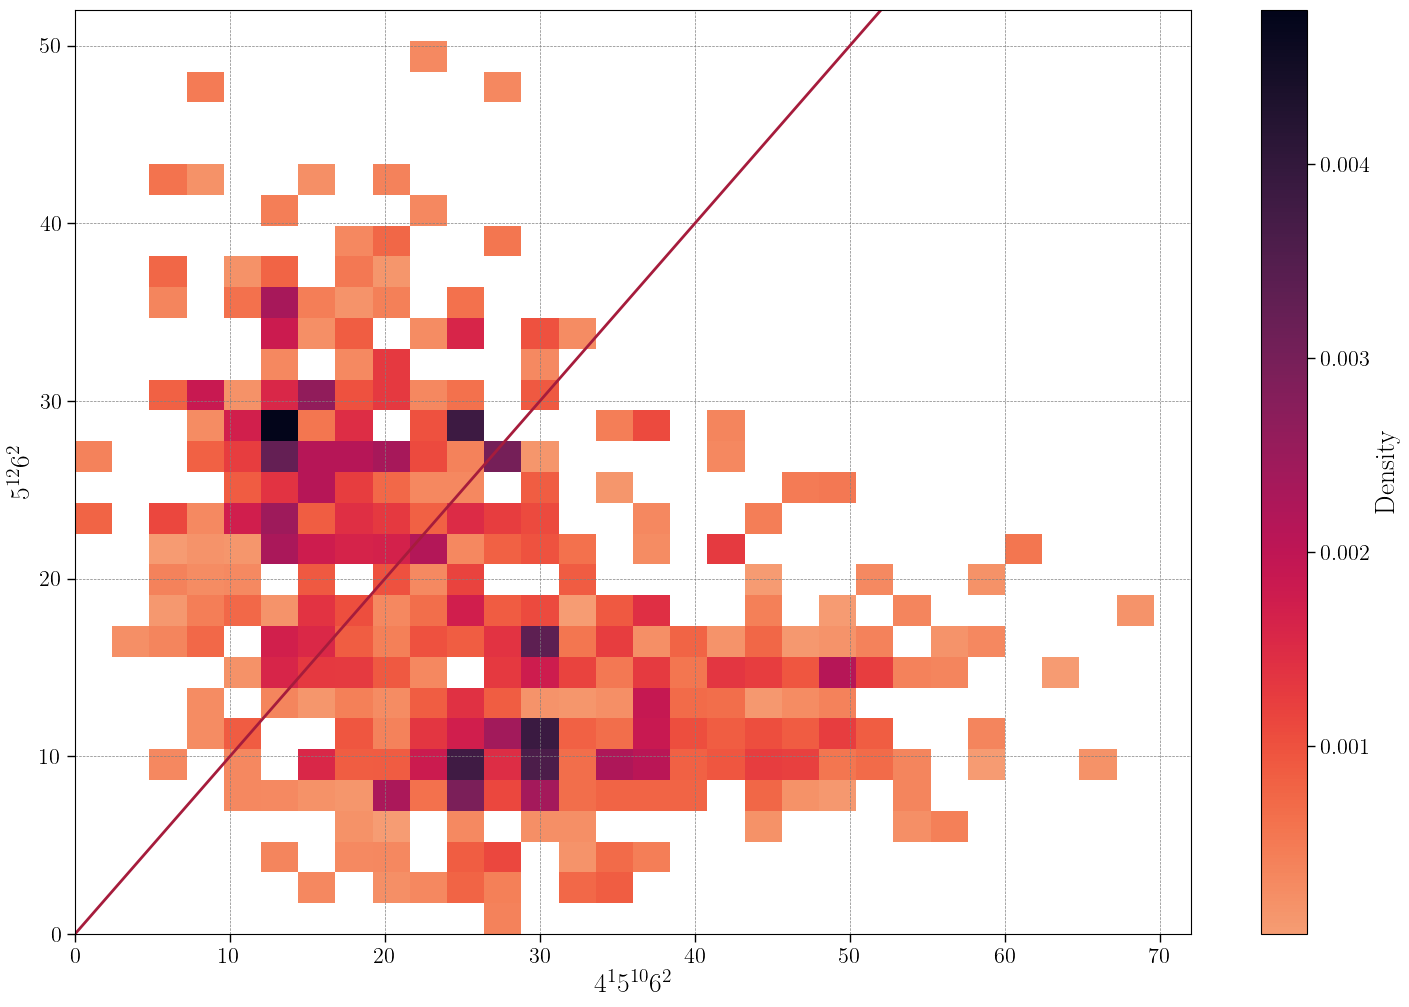

In [15]:
plt.figure(figsize=(18, 12))

counts, xedges, yedges = np.histogram2d(
    cages_4151062,
    cages_62512,
    bins=30,
    range=[[0, 72], [0, 52]],
    density = True
)

masked_counts = np.ma.masked_where(counts == 0, counts)
X, Y = np.meshgrid(xedges, yedges, indexing="ij")

plt.pcolormesh(X, Y, masked_counts, cmap=cmap)
plt.plot(x, x, color=cfg.colors['red'])
plt.colorbar(label='Density')
plt.xlabel(r'$4^15^{10}6^2$')
plt.ylabel(r'$5^{12}6^2$')
plt.xlim(0, 72)
plt.ylim(0, 52)
plt.savefig('figures/structure_analysis_histogram.png')
plt.show()


In [16]:
np.savez(
    'full_traj_histogram/histogram_data_endpoints.npz',
    counts=counts,
    xedges=xedges,
    yedges=yedges
)

## FULL TRAJECTORIES

In [17]:
all_Cages_4151062_flattened = [item for sublist in all_Cages_4151062 for item in sublist]
all_Cages_62512_flattened = [item for sublist in all_Cages_62512 for item in sublist]


In [18]:
cm_name = 'crameri:acton'
cm_name = 'seaborn:rocket'
#cm_name = 'seaborn:flare'
#cm_name = 'seaborn:mako'
#cm_name = 'crameri:acton'


cm = Colormap(f'{cm_name}')
mpl_cm = cm.to_mpl().reversed()

cmap_colors = mpl_cm(np.linspace(0, 1, 256))
truncate_point = 0.0

truncated_colors = cmap_colors[int(256 * truncate_point):]
cmap = mcolors.LinearSegmentedColormap.from_list('truncated_cmap', truncated_colors)

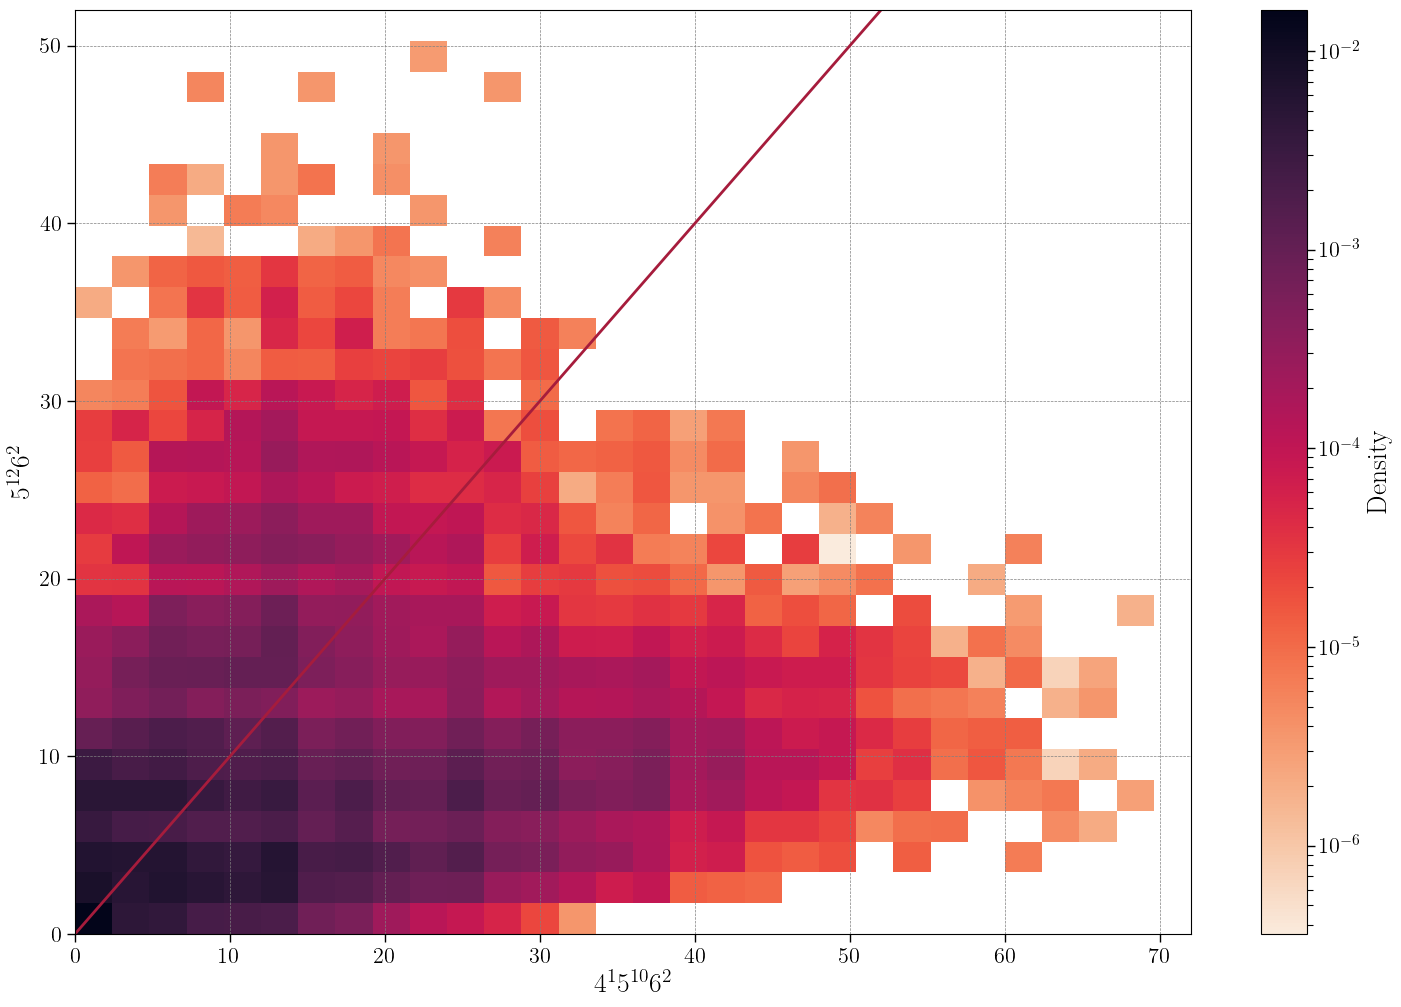

In [19]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(18, 12))

counts, xedges, yedges = np.histogram2d(
    all_Cages_4151062_flattened,
    all_Cages_62512_flattened,
    bins=30,
    range=[[0, 72], [0, 52]],
    density = True
)

masked_counts = np.ma.masked_where(counts == 0, counts)
X, Y = np.meshgrid(xedges, yedges, indexing="ij")
#cmap.set_bad(color=cmap_colors[0])

plt.pcolormesh(X, Y, counts, cmap=cmap, norm=LogNorm())
plt.plot(x, x, color=cfg.colors['red'])
plt.colorbar(label='Density')
plt.xlabel(r'$4^15^{10}6^2$')
plt.ylabel(r'$5^{12}6^2$')
plt.xlim(0, 72)
plt.ylim(0, 52)
plt.savefig('figures/structure_analysis_histogram_full_traj.png')
plt.show()

In [20]:
np.savez(
    'full_traj_histogram/histogram_data.npz',
    counts=counts,
    xedges=xedges,
    yedges=yedges
)

In [21]:
CutoffCageNumber = 5
mcg_all_frames = []
mcg_all_frames_cutoff = []
cr_all_frames = []
cr_all_frames_cutoff = []
CageCount_frames = []

for run_idx in range(12):
    CR_list = []
    run = f'run_{run_idx}'
    for dataset in run_data:
        #print(dataset)
        for idx in run_data[dataset][run]['index_succ'].keys():
            
            CageCount = run_data[dataset][run]['index_succ'][idx]['CageCount']
            
            count_62512 = run_data[dataset][run]['cages'][idx]['62512']
            count_4151062 = run_data[dataset][run]['cages'][idx]['4151062']

            mask_62512 = count_62512 >= CutoffCageNumber
            mask_4151062 = count_4151062 >= CutoffCageNumber

            combined_mask = mask_62512 & mask_4151062

            
            CR = run_data[dataset][run]['index_succ'][idx]['CageRatioFrames']

            #frames = run_data[dataset][run]['index_succ'][idx]['frames']
            mcg_values = run_data[dataset][run]['index_succ'][idx]['mcg_values'][::grade_burst]

            #print(CR)
            #print(mcg_values)



            if len(CR) != len(mcg_values):
                print(dataset, run, idx)
                #print(f'Must have same length! CR {len(CR)} MCG {len(mcg_values)} {CR} {mcg_values}  {dataset} {run} {idx}')
                #raise IndexError(f'Must have same length! CR {len(CR)} MCG {len(mcg_values)} {CR} {mcg_values}  {dataset} {run} {idx}')
                continue
                
            else: 
                CR_withcutoff = CR[combined_mask]
                mcg_withcutoff = mcg_values[combined_mask]
                
                cr_all_frames.extend(CR)
                cr_all_frames_cutoff.extend(CR_withcutoff)
                mcg_all_frames.extend(mcg_values)
                mcg_all_frames_cutoff.extend(mcg_withcutoff)
                CageCount_frames.extend(CageCount)


cr_mcg = np.vstack((mcg_all_frames_cutoff, cr_all_frames_cutoff))
mask = ~(np.isnan(cr_mcg[1, :]) | np.isinf(cr_mcg[1, :]))
clean_cr_mcg = cr_mcg[:, mask]

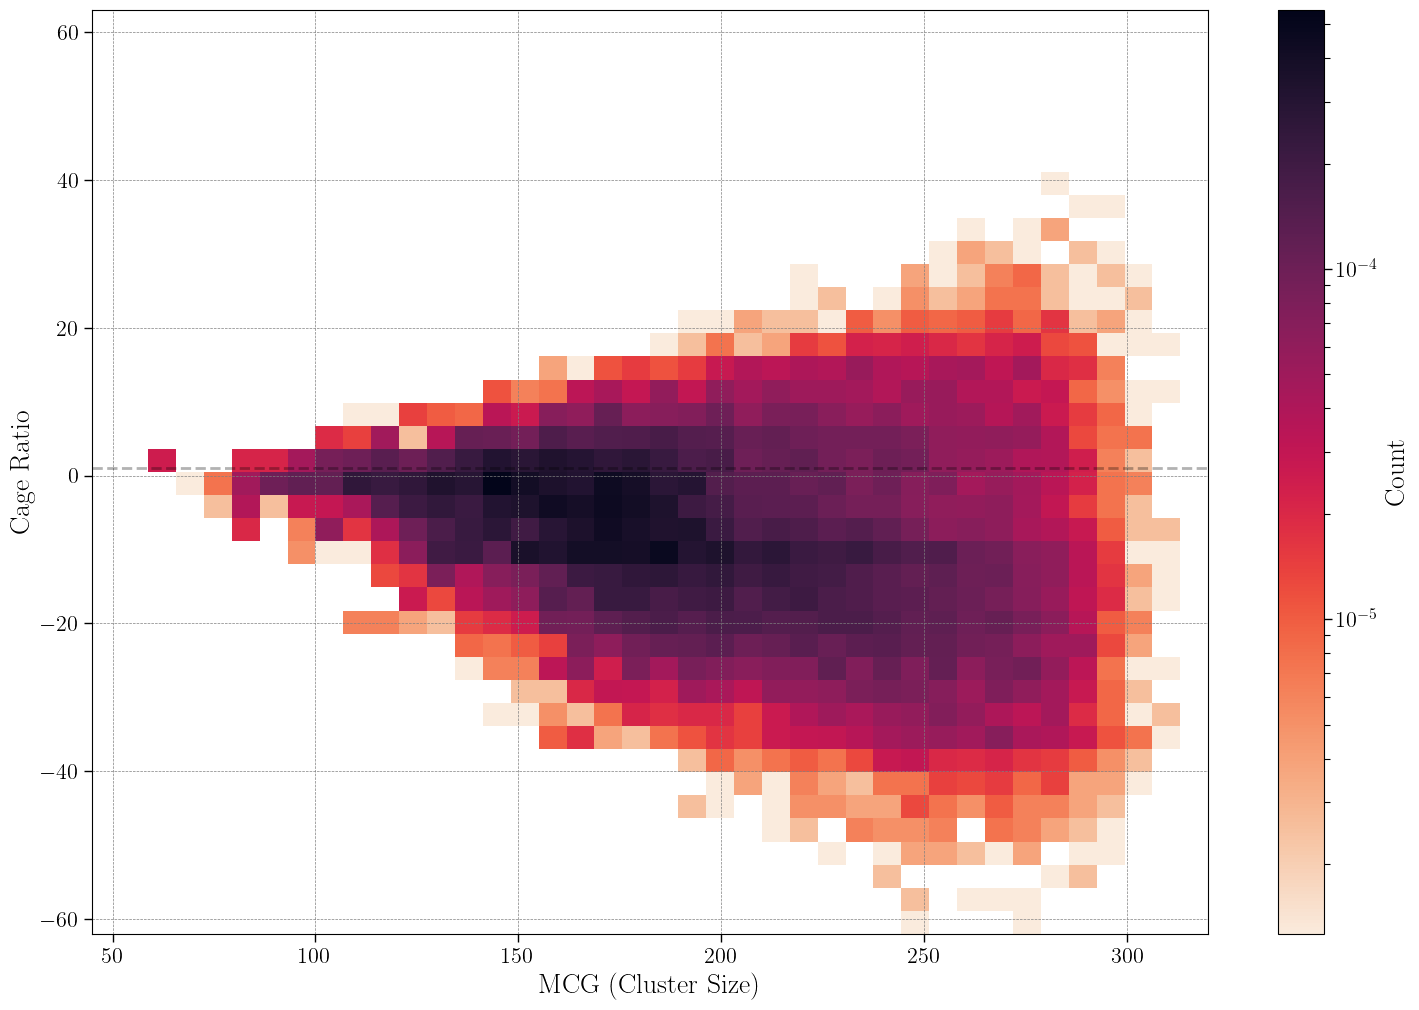

In [22]:
plt.figure(figsize=(18, 12))

counts, xedges, yedges = np.histogram2d(
    clean_cr_mcg[0, :],
    clean_cr_mcg[1, :],
    bins=40,
    density = True,
    range=[[45, 320], [-62, 63]]
)

masked_counts = np.ma.masked_where(counts == 0, counts)
X, Y = np.meshgrid(xedges, yedges, indexing="ij")

plt.axhline(y=1, color='k', linestyle='--', alpha=0.3)

plt.pcolormesh(X, Y, masked_counts, cmap=cmap, norm=LogNorm())
#plt.plot(x, x, color=cfg.colors['red'])
plt.colorbar(label='Count')
plt.xlabel(r'MCG (Cluster Size)')
plt.ylabel(r'Cage Ratio')
#plt.xlim(0, 60)
#plt.ylim(0, 35)
plt.savefig('../figures/CageHistograms/cr_vs_mcg.png')
plt.show()

np.savez(
    'full_traj_histogram/cr_vs_mcg.npz',
    counts=counts,
    xedges=xedges,
    yedges=yedges
)